# Objetivos e observações

Se existe um produto que toma os noticiarios quando há alteração de preços são os combustíveis. E se você, como um revendedor conseguisse ter uma estimativa do valor que essa mercadoria poderá possuir daqui a X tempo? Conseguiria planejar seus estoques com mais acertividade? Talvez reservar uma parte do caixa para uma compra futura maior a um preço mais baixo? As possibilidades são várias.

Nosso objetivo será analisar a evolução histórico do produto Gasolina Comum ao longo de alguns anos para tentarmos entender como conseguirimos chegar nesse objetivo.

*Observação!*
Foram retirados da análise os anos de 2021 e 2022 pois estes apresentaram distribuições muito atípicas na pré-analise (o que poderia comprometer o modelo a ser criado)

Os dados originais podem ser encontrados no site do Gov.br pelo link:
https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-e-de-glp

# Bibliotecas, Importações e Transformações Iniciais

**Importando bibliotecas**

In [ ]:
! pip install sklearn
! pip install scipy

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime as dt
import time
import scipy

**Importando dados**

In [15]:
def read_data():
    path = 'D:/Python/combustiveis/dados_historicos/'
    files_name = os.listdir(path)
    df = pd.DataFrame()
    
    for file in files_name:
        df_temp = pd.read_csv(path + file, sep=';', parse_dates=True, encoding='latin-1', low_memory=False)
        df = pd.concat([df, df_temp])
    
    df = df.drop(columns=['ï»¿Regiao - Sigla', 'Nome da Rua','Numero Rua','Complemento','Cep','Unidade de Medida'])
    nomes_colunas = {
                    'Estado - Sigla':'EstadoSigla',
                    'Municipio':'Municipio',
                    'Revenda':'Revenda',
                    'CNPJ da Revenda':'CNPJRevenda',
                    'Bairro':'Bairro',
                    'Produto':'Produto',
                    'Data da Coleta':'DataColeta',
                    'Valor de Venda':'ValorVenda',
                    'Valor de Compra':'ValorCompra',
                    'Bandeira':'Bandeira'
                     }

    df = df.rename(columns=nomes_colunas)
    return df

In [16]:
df = read_data()
df.head()

,EstadoSigla,Municipio,Revenda,CNPJRevenda,Bairro,Produto,DataColeta,ValorVenda,ValorCompra,Bandeira
0,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,BONSUCESSO,GASOLINA,03/01/2017,"3,699","3,1874",PETROBRAS DISTRIBUIDORA S.A.
1,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,BONSUCESSO,ETANOL,03/01/2017,"2,899","2,4963",PETROBRAS DISTRIBUIDORA S.A.
2,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,BONSUCESSO,DIESEL,03/01/2017,"2,959","2,5284",PETROBRAS DISTRIBUIDORA S.A.
3,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,BONSUCESSO,DIESEL S10,03/01/2017,"3,079","2,6658",PETROBRAS DISTRIBUIDORA S.A.
4,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,BONSUCESSO,GNV,03/01/2017,"2,099",NaN,PETROBRAS DISTRIBUIDORA S.A.


In [17]:
#Filtrando somente o produto Gasolina
df = df.loc[df['Produto']=='GASOLINA']

**Criando Backup**

**df = DataFrame (Original) | dfb = DataFrameBackup (Usado para análise)**

In [18]:
dfb = df.copy()

In [19]:
dfb.shape

(1052834, 10)

In [20]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1052834 entries, 0 to 222632
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   EstadoSigla  1052834 non-null  object
 1   Municipio    1052834 non-null  object
 2   Revenda      1052834 non-null  object
 3   CNPJRevenda  1052834 non-null  object
 4   Bairro       1049190 non-null  object
 5   Produto      1052834 non-null  object
 6   DataColeta   1052834 non-null  object
 7   ValorVenda   1052834 non-null  object
 8   ValorCompra  419178 non-null   object
 9   Bandeira     1052834 non-null  object
dtypes: object(10)
memory usage: 88.4+ MB


In [21]:
dfb.isnull().sum()

EstadoSigla         0
Municipio           0
Revenda             0
CNPJRevenda         0
Bairro           3644
Produto             0
DataColeta          0
ValorVenda          0
ValorCompra    633656
Bandeira            0
dtype: int64

**Adicionando Colunas Auxiliares e Fazendo Conversões**

In [22]:
def float_converter(colunas, dataframe):
    for coluna in colunas:
        try:
            dataframe[coluna] = dataframe[coluna].str.replace(',','.').astype(float)
            print(f'{coluna} convertido com sucesso para {column_type}')
        except:
            column_type = type(dataframe[coluna].dtype)
            print(f'Uma excessão ocorreu porque {coluna} é do tipo {column_type}')
            
            
def add_dates(colunas, dataframe):
    for coluna in colunas:
        dfb[coluna] = pd.to_datetime(dfb[coluna],format='mixed')
        dfb['mes'] = dfb[coluna].dt.month.astype(int)
        dfb['ano'] = dfb[coluna].dt.year.astype(int)
        dfb['dia'] = dfb[coluna].dt.day.astype(int)
        dfb['mes-ano'] = dfb[coluna].dt.strftime('%Y-%m')

In [23]:
float_converter(['ValorVenda','ValorCompra'], dfb)
add_dates(['DataColeta'], dfb)

Uma excessão ocorreu porque ValorVenda é do tipo <class 'numpy.dtypes.Float64DType'>
ValorCompra convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


In [24]:
#Coluna de Lucro Bruto.
dfb['lucrobruto'] = dfb['ValorVenda'] - dfb['ValorCompra']

#Coluna de Mrg.
dfb['mrg'] = (dfb['ValorVenda']-dfb['ValorCompra'])/dfb['ValorVenda']

# Análise Exploratória - Variáveis Quantitativas

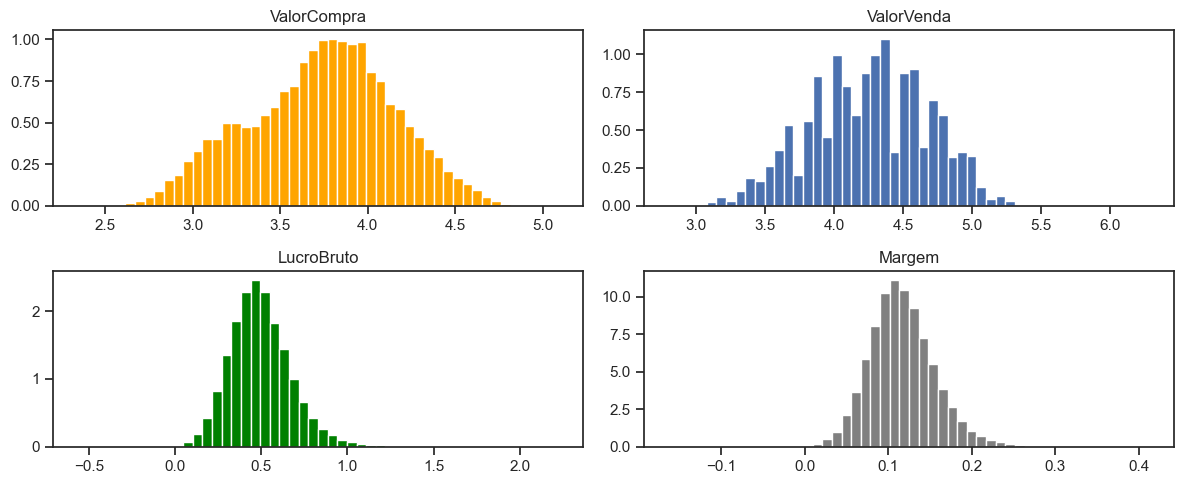

In [25]:
#Anaslisando Valores númericos
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.title('ValorCompra')
plt.hist(x=dfb['ValorCompra'],color='orange',density=True,bins=50)
plt.subplot(2,2,2)
plt.title('ValorVenda')
plt.hist(x=dfb['ValorVenda'],density=True,bins=50)
plt.subplot(2,2,3)
plt.title('LucroBruto')
plt.hist(x=dfb['lucrobruto'],color='green',density=True,bins=50)
plt.subplot(2,2,4)
plt.title('Margem')
plt.hist(x=dfb['mrg'],color='gray',density=True,bins=50)
plt.tight_layout()
plt.show()

Usualmente vemos que no mercado de postos de gasolina a "briga" entre os revendedores é literalmente disputada em centavos de diferença, em relação ao preço de venda.

Agora percebam que interessante a distribuição do *LucroBruto e Margem*, estão bem concentrados em torno de uma média, o lucro de *0.5 centavos* e a margem de *0.12 ou 12%*. Então, por mais que existam variações no Valor de Compra e Venda, o Valor de Venda se ajusta ao de Compra de modo a manter uma "margem padrão"

Outro ponto, na preparação inicial dos dados, verificamos que 633.656 registros de compra estão vazios na base. Isso possivelmente está impactando na distribuição do valor de compra.

Podemos tentar estimar esses valores com base nos valores de margem (em percentual %) observados. Porém não faremos por hora.

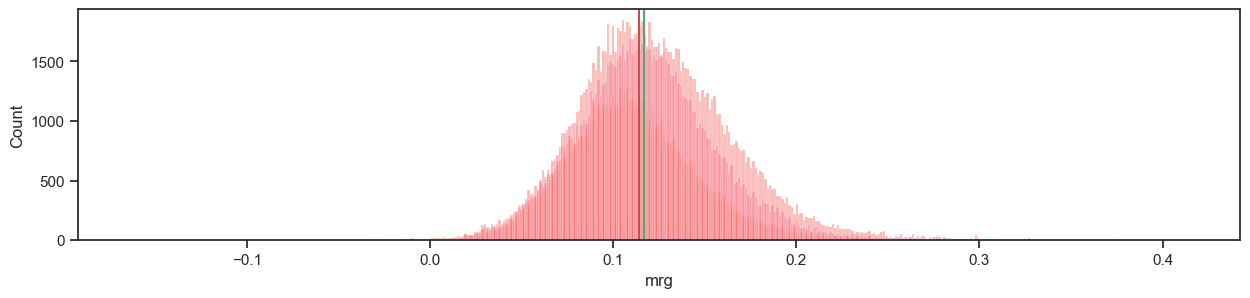

count    419178.000000
mean          0.116847
std           0.039549
min          -0.163479
25%           0.090638
50%           0.113979
75%           0.140103
max           0.413534
Name: mrg, dtype: float64


In [26]:
#Analisando distribuição das margens por Bandeiras/Distribuidoras
plt.figure(figsize=(15,3))
data = dfb[['mrg','Bandeira']].dropna()
sb.histplot(data=data, x="mrg", hue="Bandeira", legend=False)
plt.axvline(x=dfb['mrg'].median(),color='r')
plt.axvline(x=dfb['mrg'].mean(),color='g')
plt.show()
print(dfb['mrg'].describe())

Analisando a distribuição das margens de lucros, **mesmo separando por bandeira**, observamos que realmente é uma distribuição bem homogênea *Média de 11,3% - Desvio Padrdão de 4% - para um total de 419.178 valores*, com isso temos mais segurança para inferir o preço de compra dos registros que apareceram com valores de compra zerados. Mas não o faremos por hora, somente na fase preparação dos dados para o modelo

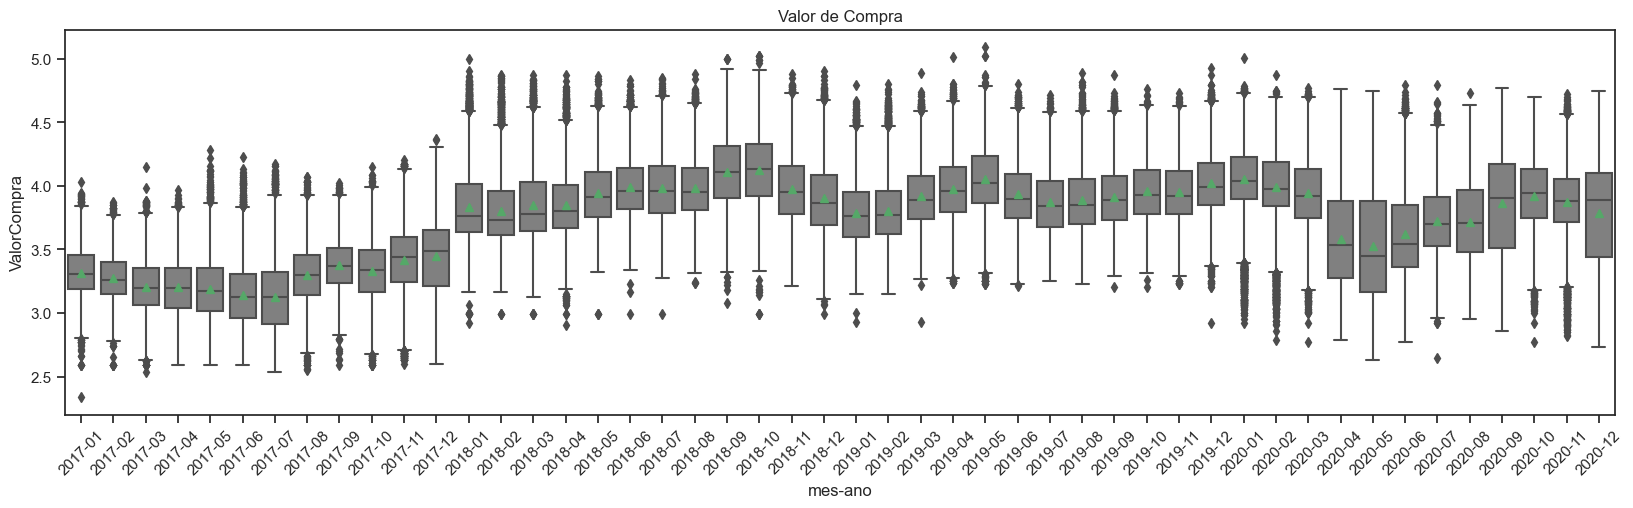

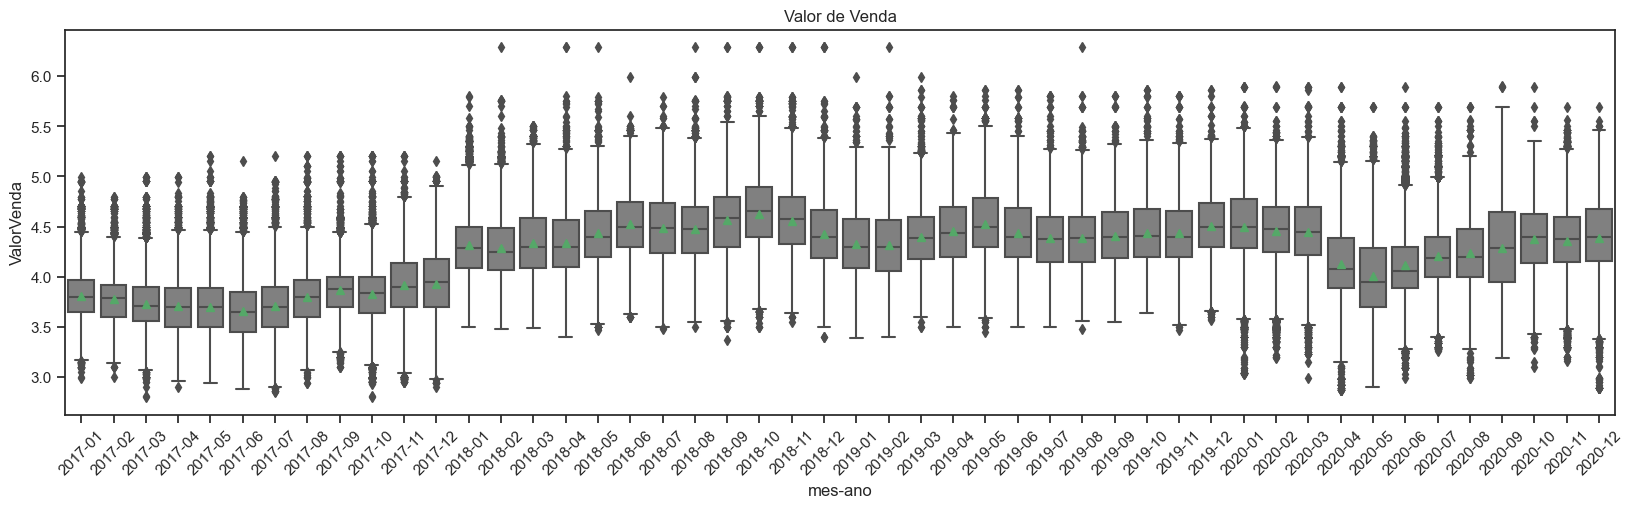

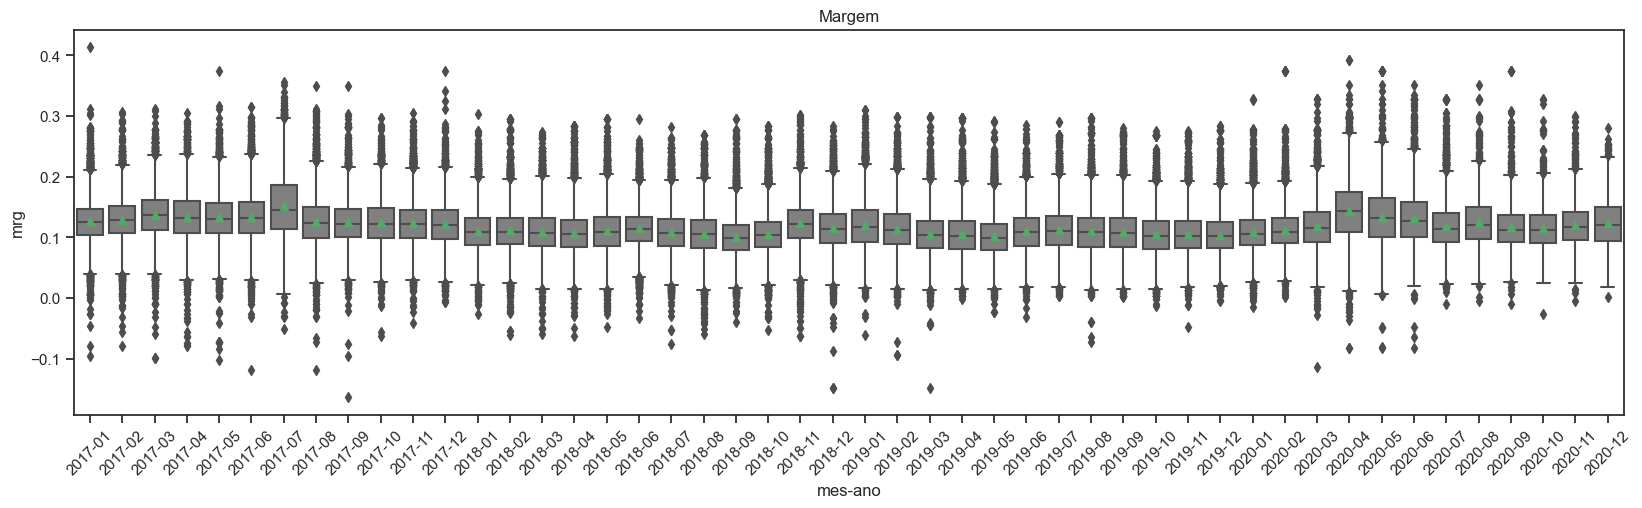

In [27]:
data = dfb[['DataColeta','mes','mes-ano','ValorCompra']]
plt.figure(figsize=(20,5))
plt.title('Valor de Compra')
boxplot = sb.boxplot(data=dfb.sort_values('DataColeta'), x='mes-ano',y='ValorCompra',showmeans=True, color='gray')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()

data = dfb[['DataColeta','mes','mes-ano','ValorVenda']]
plt.figure(figsize=(20,5))
plt.title('Valor de Venda')
boxplot = sb.boxplot(data=dfb.sort_values('DataColeta'), x='mes-ano',y='ValorVenda',showmeans=True, color='gray')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()


data = dfb[['DataColeta','mes','mes-ano','mrg']]
plt.figure(figsize=(20,5))
plt.title('Margem')
boxplot = sb.boxplot(data=dfb.sort_values('DataColeta'), x='mes-ano',y='mrg',showmeans=True, color='gray')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()

Olhem só que interessante! Mesmo ao longo de 4 anos a *Margem se manteve dentro de uma mesma média* apesar da presença de outliers em todos os anos.

Em relação ao *Valor de Compra e Venda* como esperado, eles vieram sofrendo uma tendência de aumento, isso é esperado por uma série de motivos, um deles a inflação.

**CORRELAÇÕES**

Em estatística é comum analisarmos a correlção existente entre variáveis númericas, isso nos permite enxergar se há chance de uma variável está impactando da variação de outra.

Abaixo usaremos dois cálculos diferentes para essa análise *(Spearman e Pearson)* o intuito será verificar se um irá detectar algo que o outro "deixou passar"

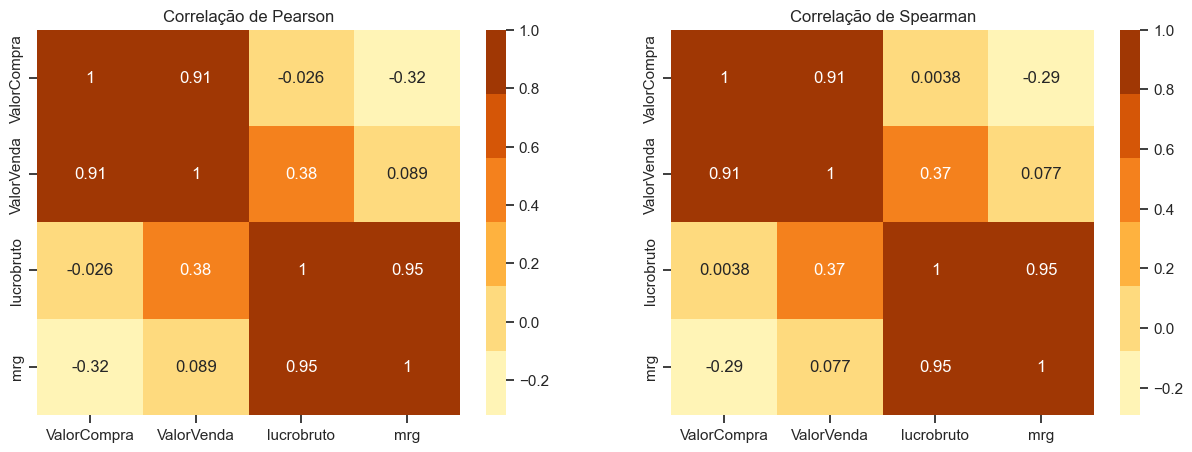

In [37]:
var_numericas = ['ValorCompra','ValorVenda','lucrobruto','mrg']

palette = sb.color_palette("YlOrBr", as_cmap=False)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1,title='Correlação de Pearson')
sb.heatmap(data=dfb[var_numericas].corr(method='pearson'),annot=True, cmap=palette)

plt.subplot(1,2,2,title='Correlação de Spearman')
sb.heatmap(data=dfb[var_numericas].corr(method='spearman'),annot=True, cmap=palette)
plt.show()

Os pontos mais próximos do *laranja - valor de 1.0* irão indicar uma relação positiva, quanto mais próximo do *branco - valor de 0.2* uma relação negativa.

*Relações Positivas:*
Nos mostram que de fato o *Valor de Compra e Venda* estão intimamente ligados, quando um aumenta, o outro tende a aumentar também. Da mesma forma com o *Lucro Bruto e Margem*.

*Relações Negativas:*
Aqui temos algumas observações interessantes, *Valor de Compra e Margem* estão ligados de maneira negativa, quando um aumenta o outro tende a diminuir. Faz sentido! Lembram que a Margem se mostrava bastante homogênea? Pois é, mesmo que o produto fique mais caro, e seu preço aumente, *isso não necessariamente irá implicar em um Lucro/Margem maior.*

# Análise Exploratória - Variáveis Qualitativas

Vamos analisar como o Valor de Compra se comporta em relação a:
- Bandeira
- Estado

**BANDEIRA**

In [46]:
#Selecionado bandeiras/distribuidoras com maior frequência na base
top_band = dfb[['Bandeira']].value_counts()
top_band = top_band.head(5)
print(top_band)

#Criando listas com elas, será útil para filtragem logo mais
bandeiras = list(top_band.index)
bandeiras_tratadas = []
for i in bandeiras:
    bandeiras_tratadas.append(i[0])

#Verificando quanto % dos registros são contemplados por essas bandeiras
total_count = len(dfb['Bandeira'])
print(f'Essas bandeiras representam {round(top_band.sum()/total_count,2)*100}% do total de registros')

#Filtrando DataFrame por essas bandeiras
dados_top_band = dfb.loc[dfb['Bandeira'].isin(bandeiras_tratadas)]

Bandeira                    
BRANCA                          347823
PETROBRAS DISTRIBUIDORA S.A.    254931
IPIRANGA                        186982
RAIZEN                          163392
ALESAT                           26772
Name: count, dtype: int64
Essas bandeiras representam 93.0% do total de registros


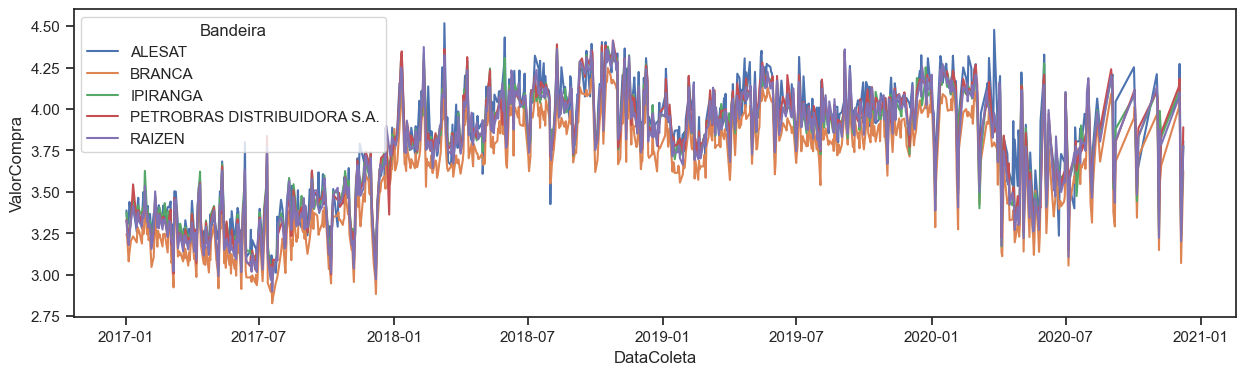

In [47]:
data = dados_top_band.groupby(['DataColeta','Bandeira'])['ValorCompra'].mean()
data = data.reset_index()
plt.figure(figsize=(15,4))
sb.lineplot(data, x='DataColeta',y='ValorCompra',hue='Bandeira')
plt.show()

Uow! Reparem como as linhas parecem está sobrepostas boa parte do tempo, *indicando que mesmo entre as bandeiras a diferença de valores é muito pouca.*

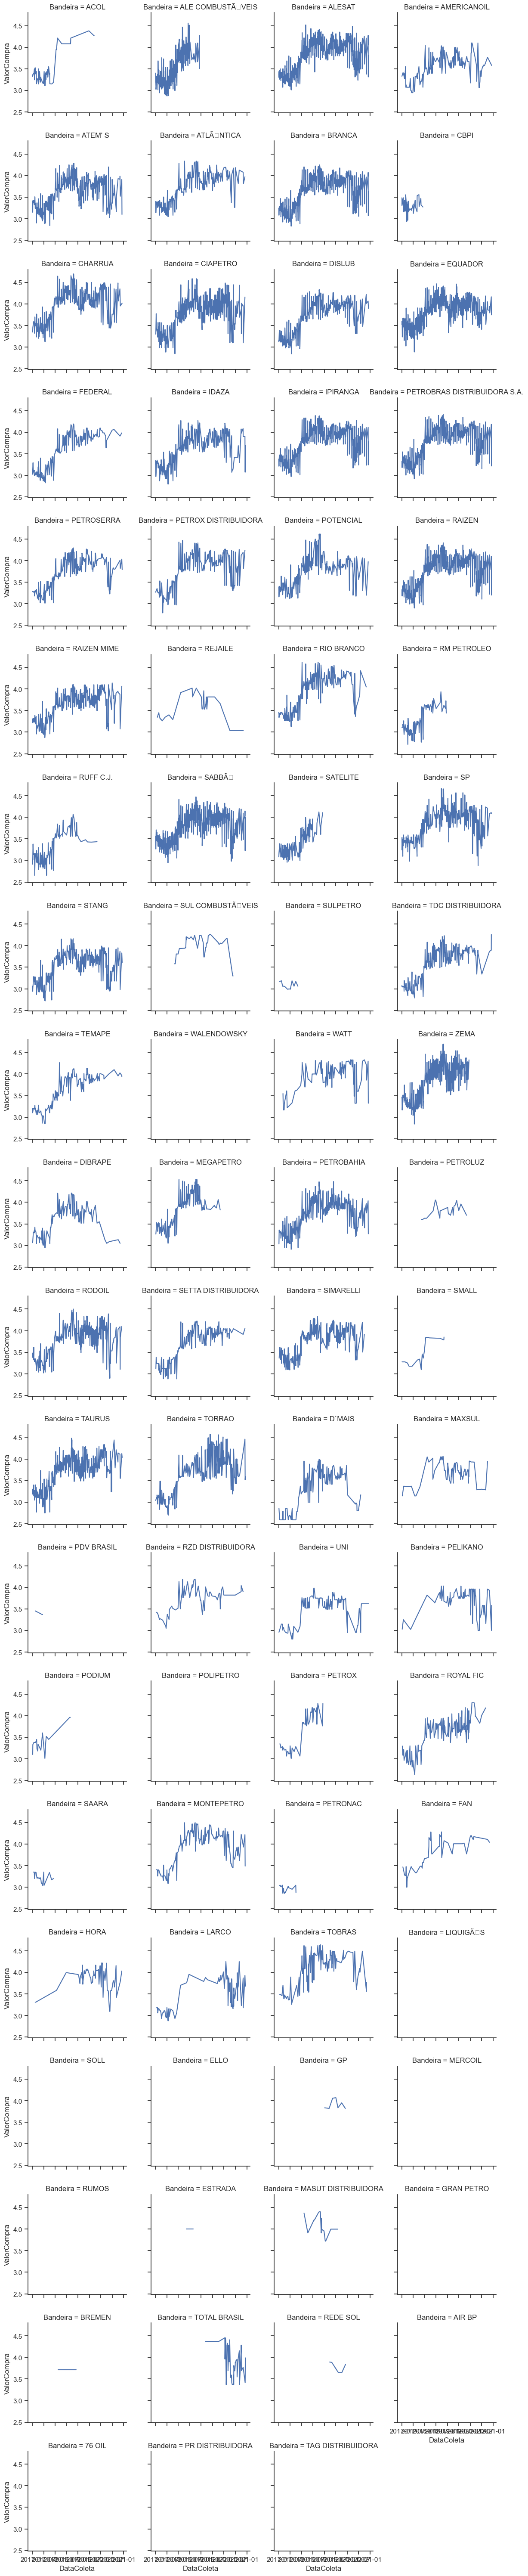

In [48]:
import warnings
warnings.filterwarnings("ignore")
data = dfb.groupby(['DataColeta','Bandeira'])['ValorCompra'].mean()
data = data.reset_index()

grid = sb.FacetGrid(data,col='Bandeira',col_wrap=4,dropna=True)
grid.map(sb.lineplot, 'DataColeta', 'ValorCompra')
plt.show()

A figura acima, apesar de não muito agradável aos olhos. Foi criada com o objetivo de nos ajudar a verificar a evolução desses valores *bandeira a bandeira*. Vamos iniciar a análise por Estado de maneira semelhante.

**ESTADO (UF)**

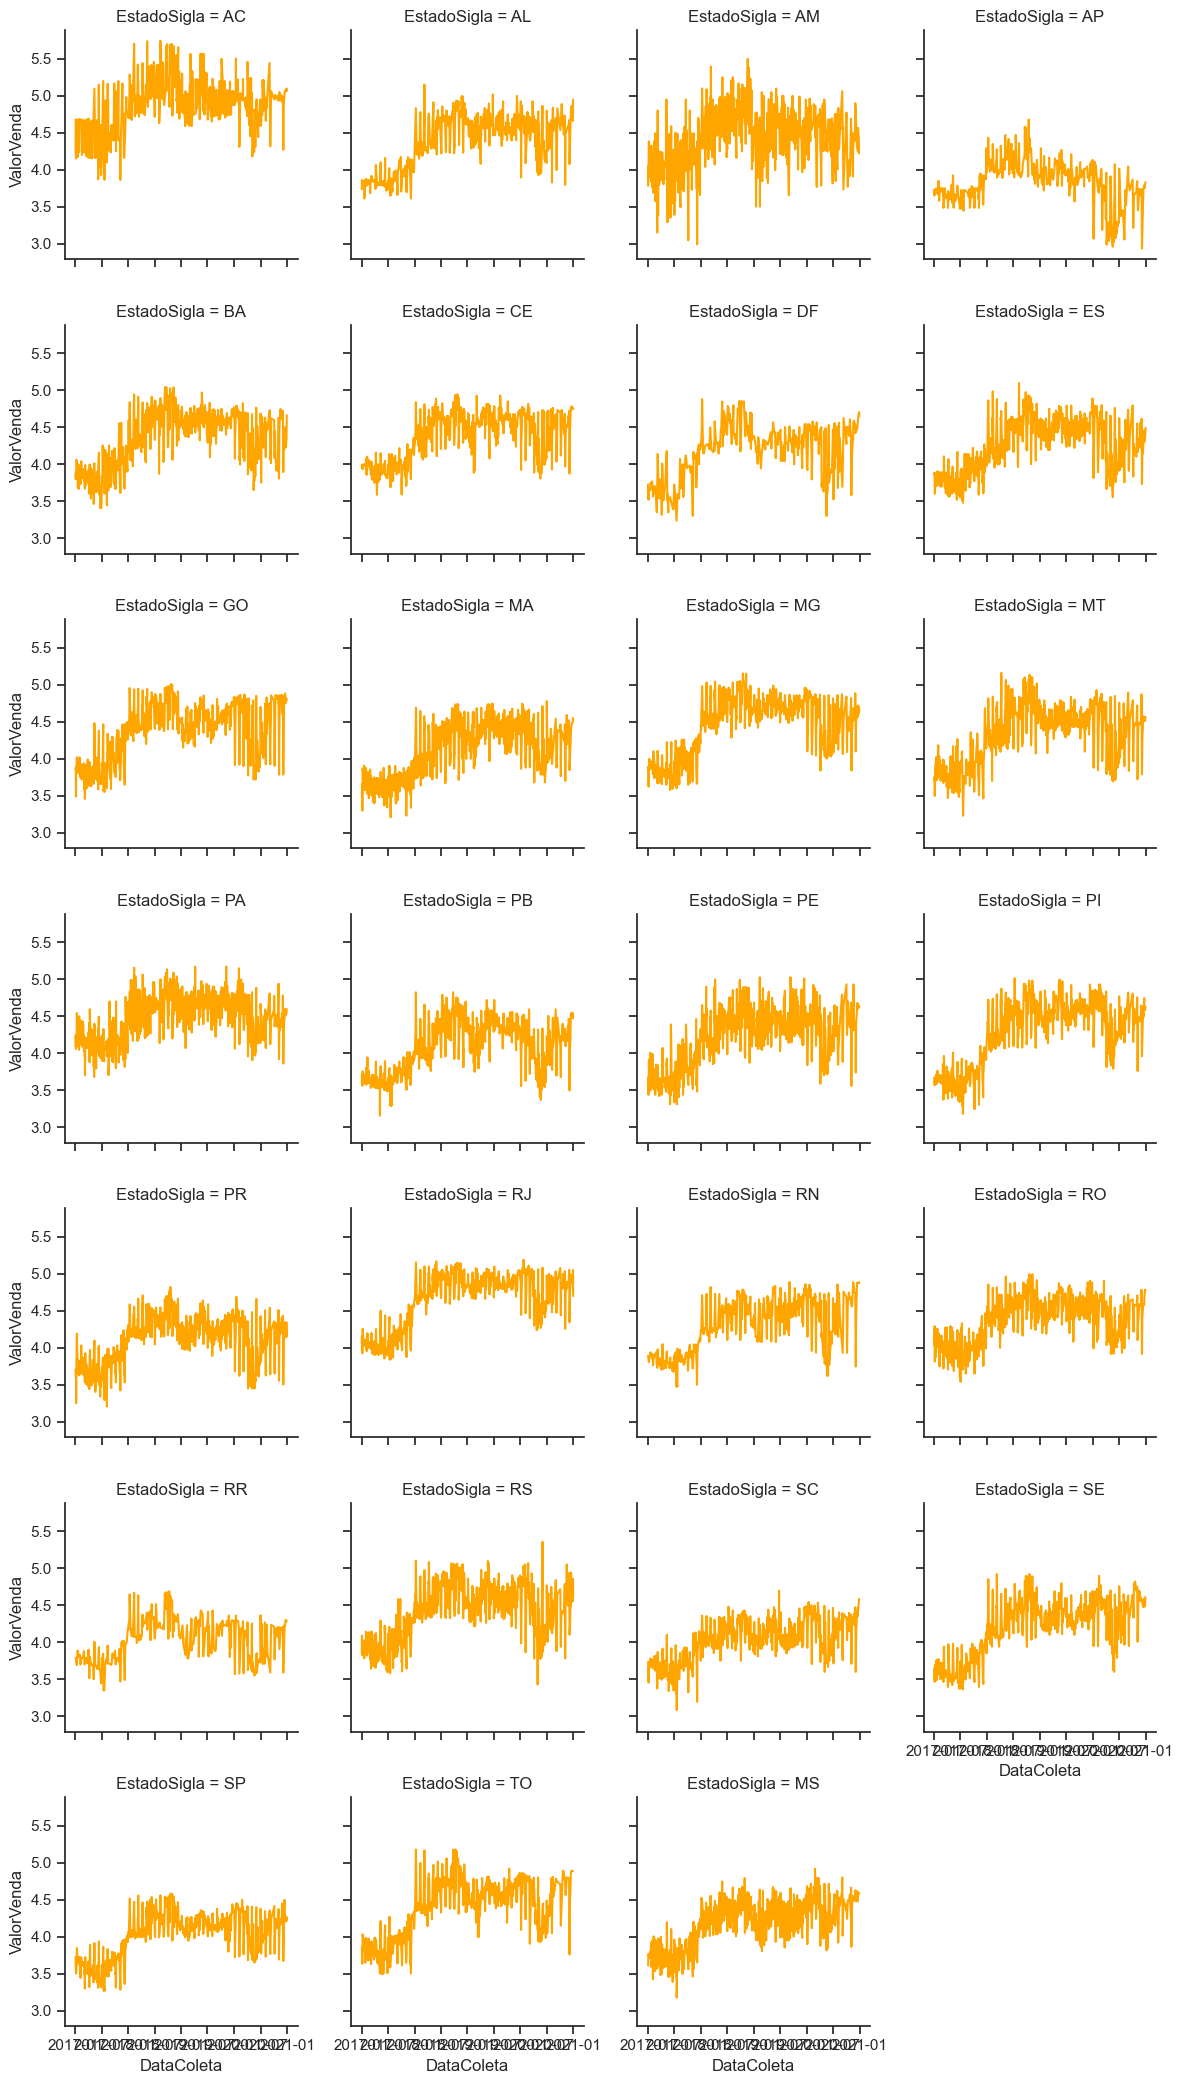

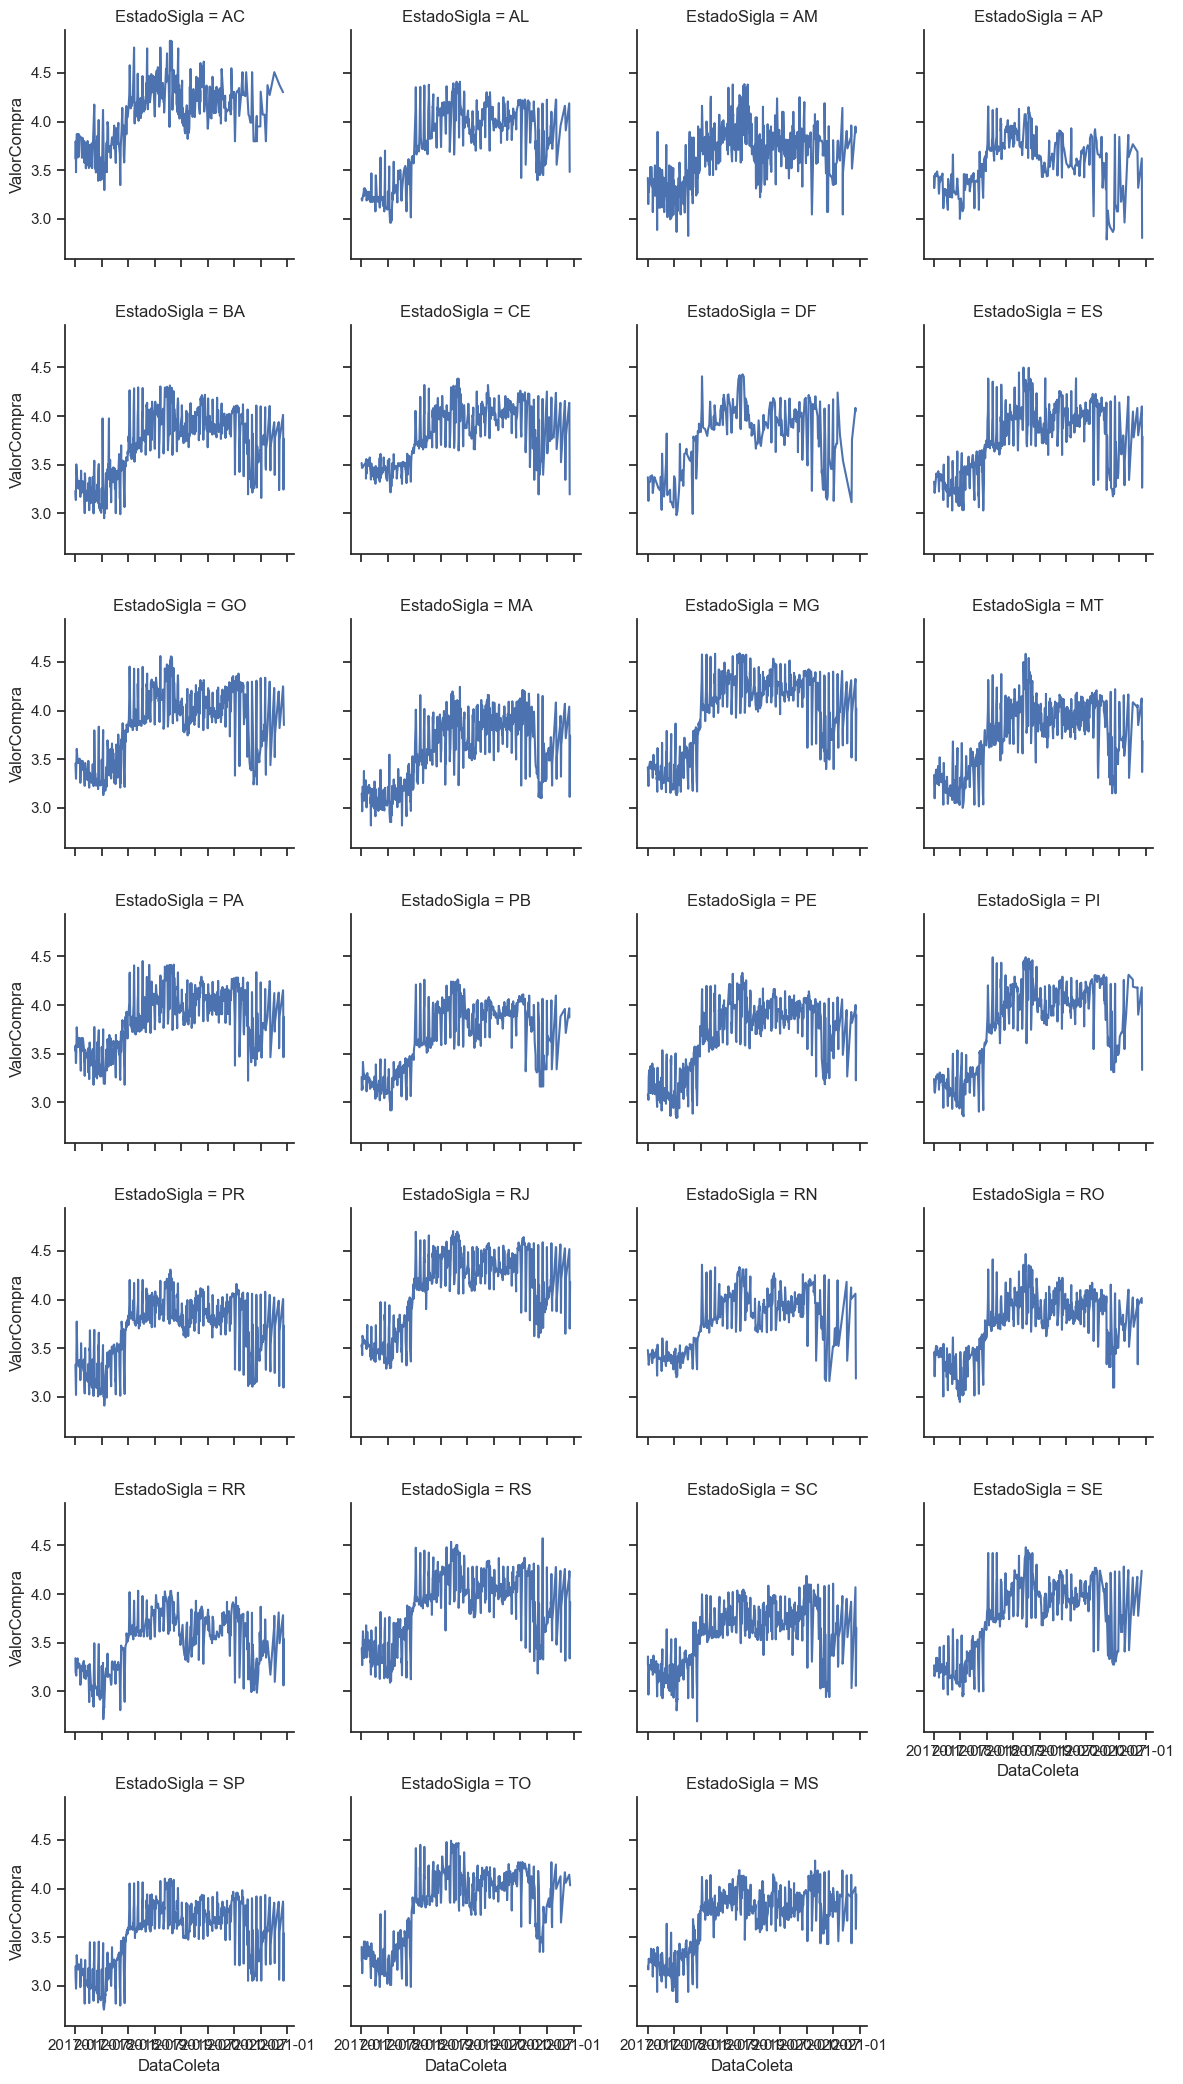

In [49]:
#Evolução ao longo do tempo
data = dfb.groupby(['DataColeta','EstadoSigla'])[['ValorVenda','ValorCompra']].mean()
data = data.reset_index()

grid = sb.FacetGrid(data,col='EstadoSigla',col_wrap=4)
grid.map(sb.lineplot, 'DataColeta', 'ValorVenda',color='orange')
plt.show()

grid = sb.FacetGrid(data,col='EstadoSigla',col_wrap=4)
grid.map(sb.lineplot, 'DataColeta', 'ValorCompra')
plt.show()

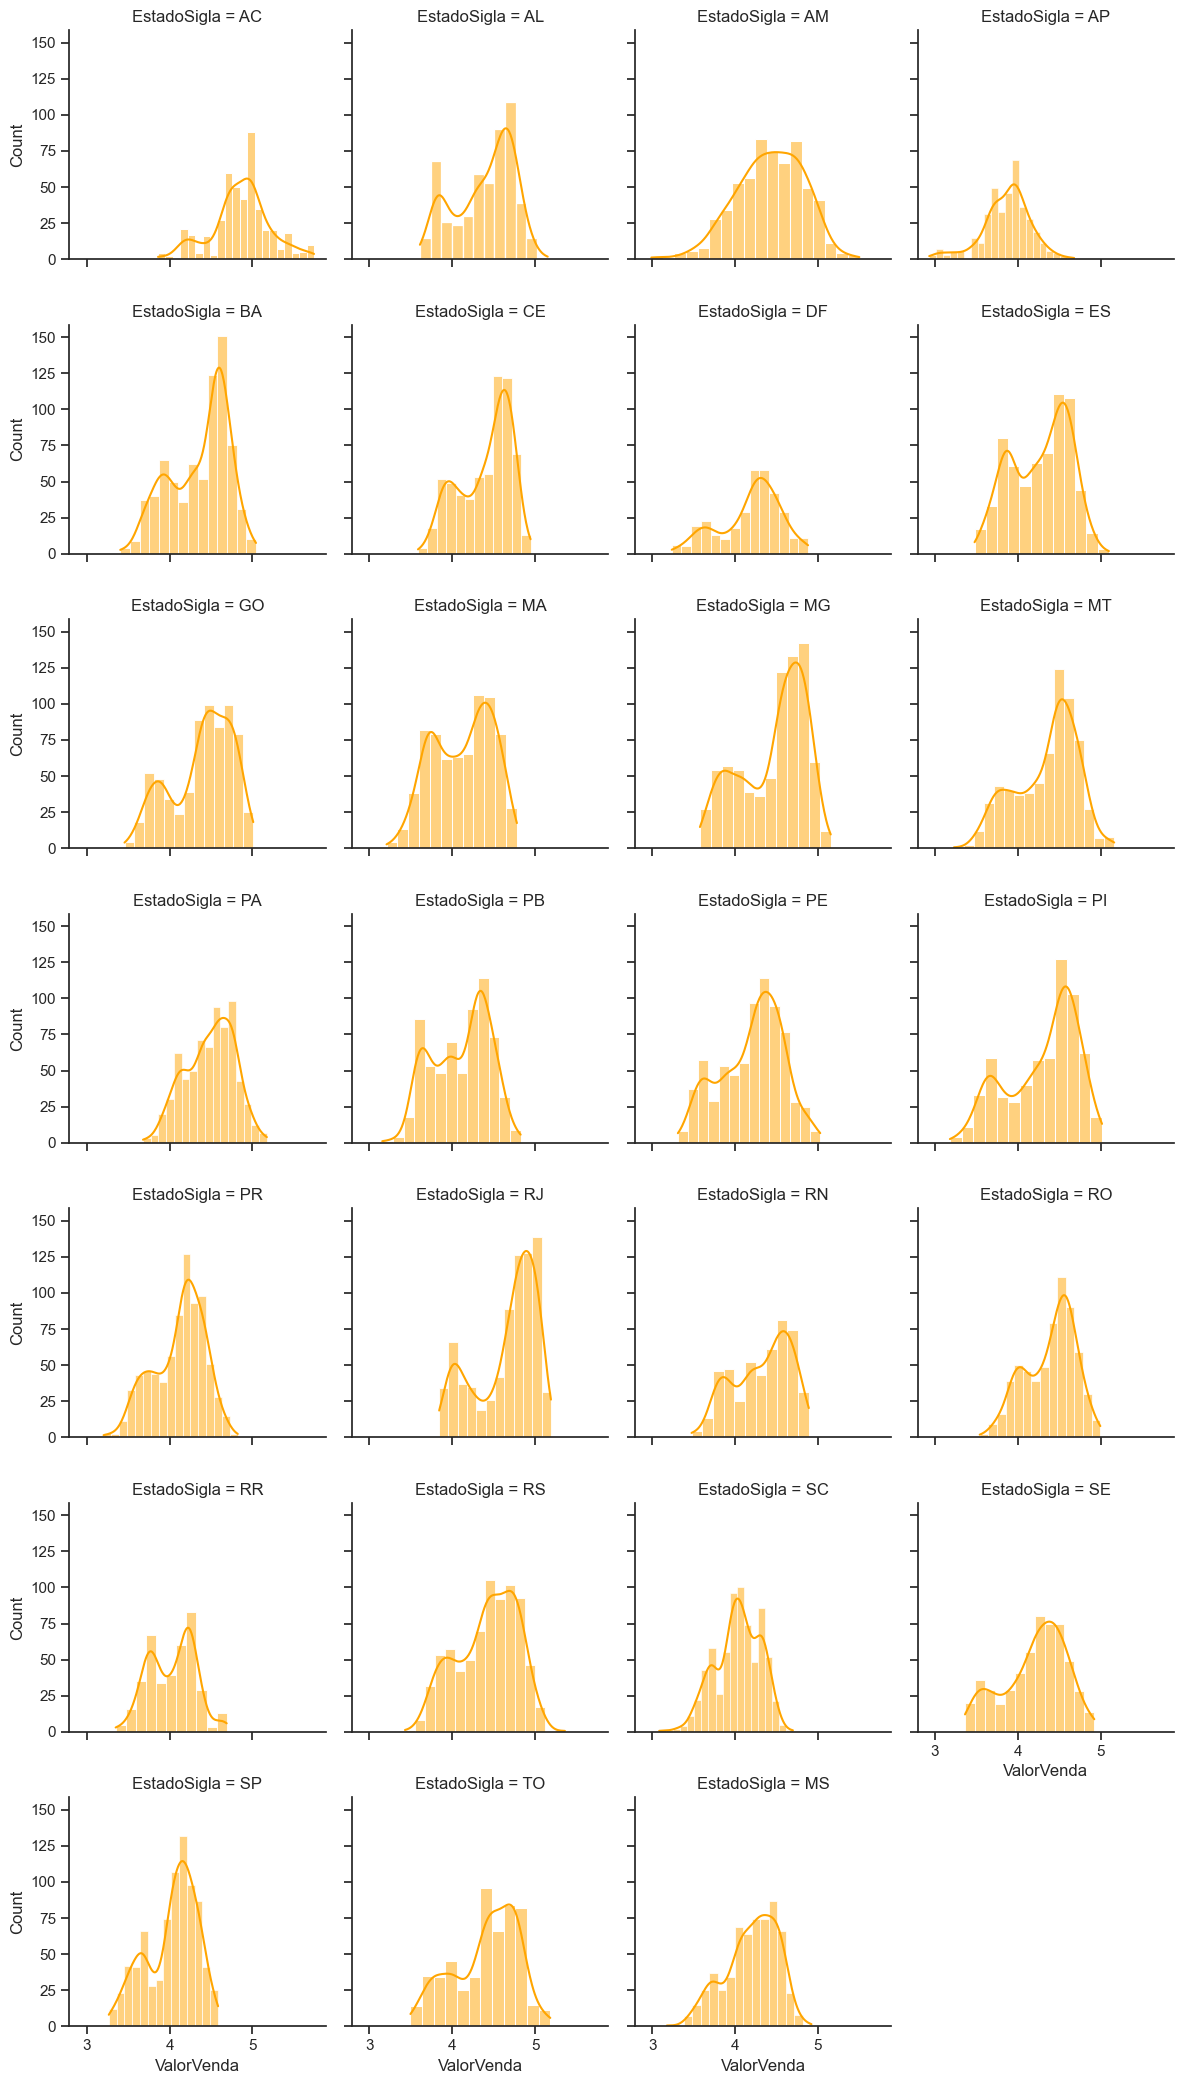

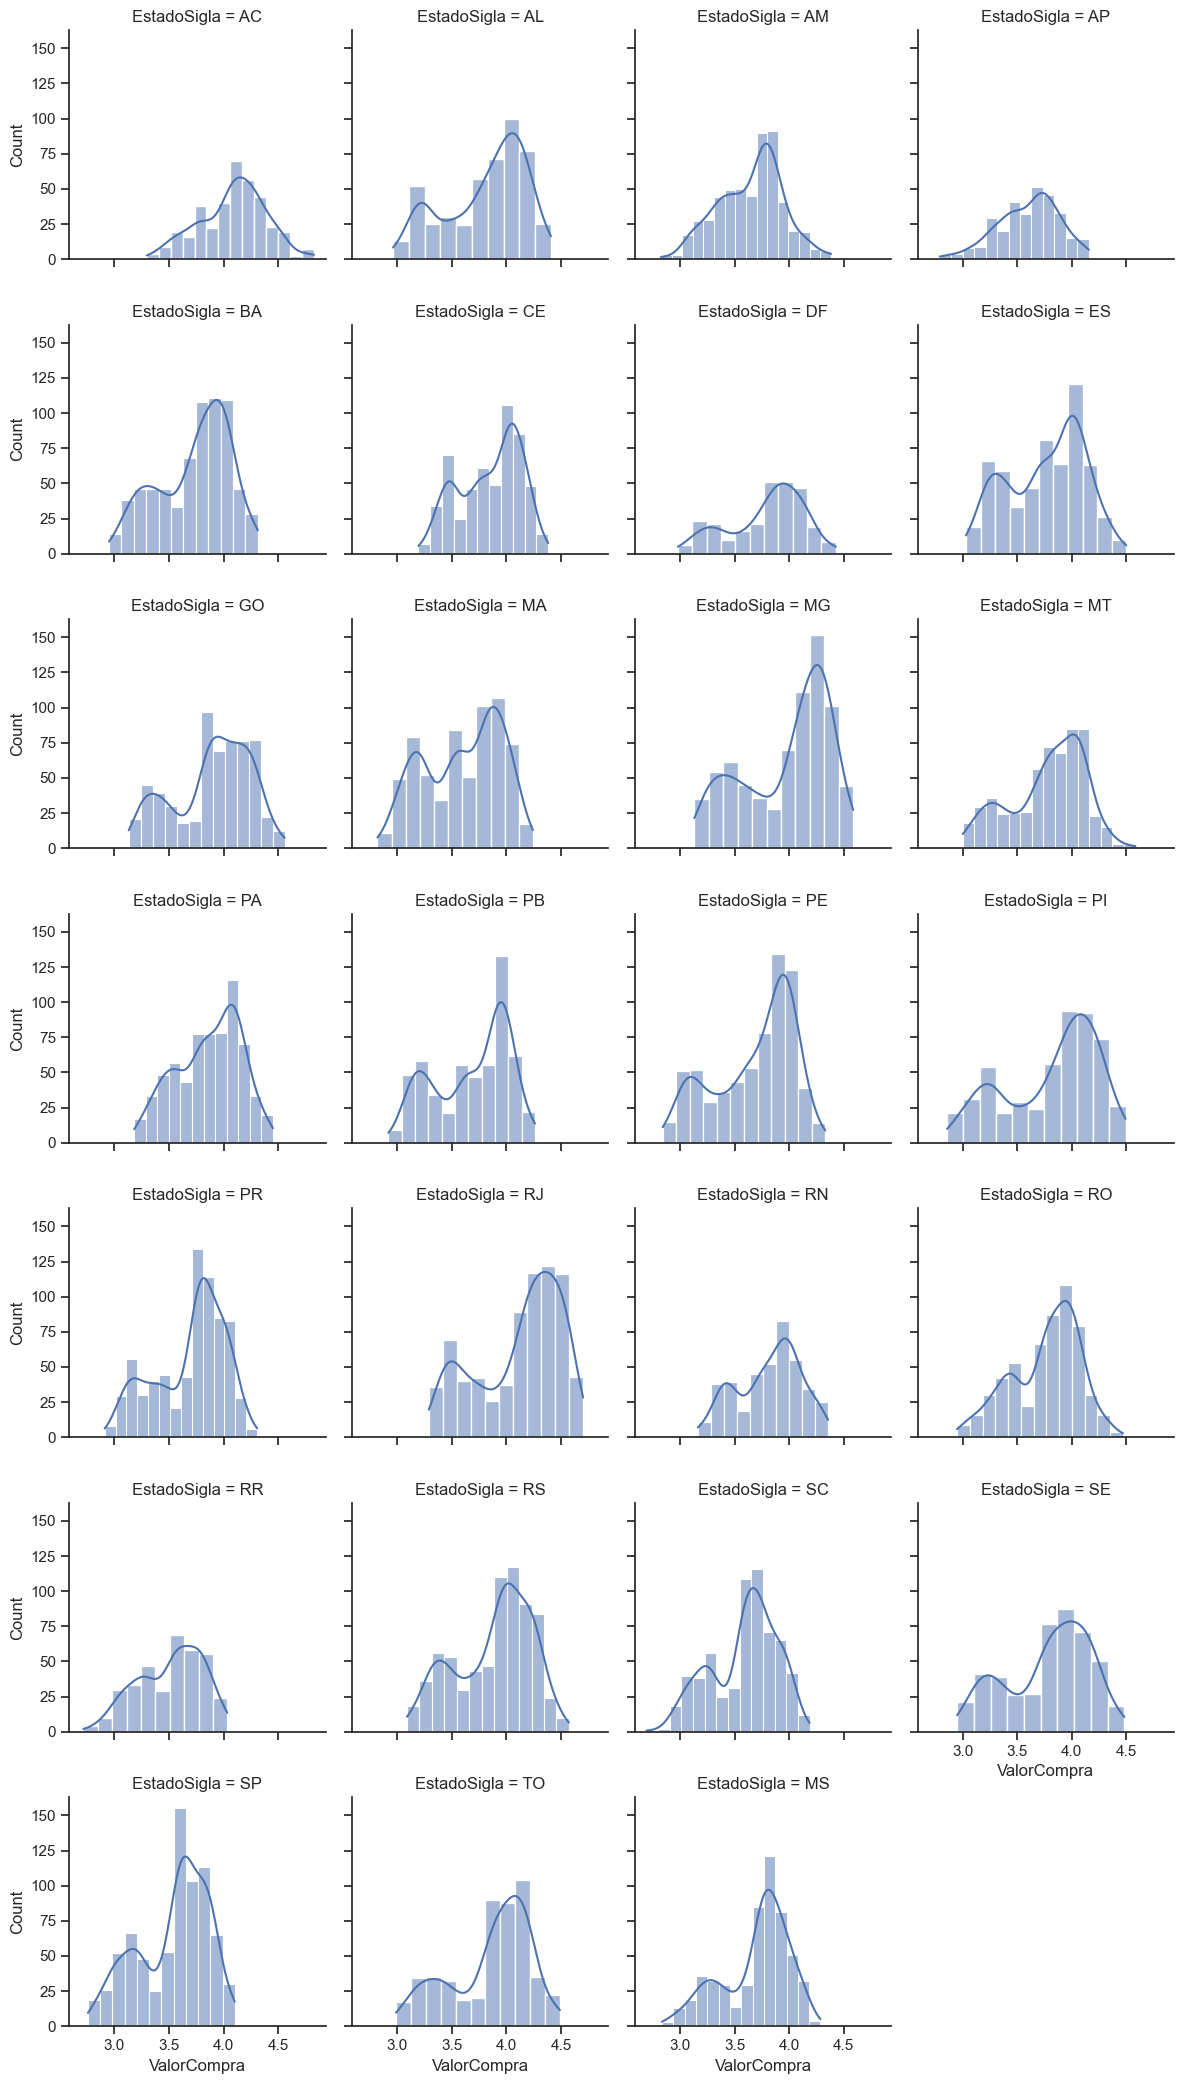

In [50]:
#Distribuição
data = dfb.groupby(['DataColeta','EstadoSigla'])[['ValorVenda','ValorCompra']].mean()
data = data.reset_index()

grid = sb.FacetGrid(data,col='EstadoSigla',col_wrap=4)
grid.map(sb.histplot, 'ValorVenda',kde=True,color='orange')
plt.show()

grid = sb.FacetGrid(data,col='EstadoSigla',col_wrap=4)
grid.map(sb.histplot, 'ValorCompra',kde=True)
plt.show()

Como esperado, os valores de venda e compra entre os estados e bandeira são bastante semelhantes. O que corrobora a observação inicial de que *não iríamos encontrar muitas variações nesses valores mesmo separando em estratos*, apesar de que cada centavo a mais ou a menos possui grande impacto nesse tipo de mercado.

# Conclusão da análise

Analisamos os valores da Gasolina Comum do ano de 2017 até 2020, e o que podemos observar de interessante é:

*Margem e Lucro sem grandes variações:* Sim, mesmo com o aumento dos valores de compra e venda esses dois valores se mantiveram bastante constantes ao longo dos anos.

*Mesmo entre estados e distribuidoras, não houveram grandes diferenças:* Mesmo segmentado a análise por estratos, as distribuições dos valores avaliados se mostraram semelhantes.

*Aumento do Valores de Compra de Venda:* Apesar da margem "constante" e não observamos diferença entre as distribuições estratificadas **houveram sim aumentos nos valores e nas suas variações**

# Preparação dos dados para o modelo

In [ ]:
print(f"Valores de Compra antes: \n {dfb['ValorCompra'].describe()}")
plt.figure(figsize=(15,3))
sb.histplot(data=dfb['ValorCompra'],bins=50)
plt.axvline(x=dfb['ValorCompra'].median(),color='r')
plt.axvline(x=dfb['ValorCompra'].mean(),color='g')
plt.show()


#Pegando o intervalo de 8%-13% como margem base para preencher os valores vazios
#Lucro Bruto = ValorVenda - ValorCompra LOGO ValorCompra = ValorVenda - LucroBruto (ValorVenda * Mrg)
dfb['ValorCompra'] = dfb['ValorCompra'].fillna(dfb['ValorVenda']-dfb['ValorVenda']*np.random.choice([0.08, 0.09, 0.10, 0.11, 0.12, 0.13]))

print(f"Valores de Compra Depois: \n {dfb['ValorCompra'].describe()}")
plt.figure(figsize=(15,3))
sb.histplot(data=dfb['ValorCompra'],bins=50)
plt.axvline(x=dfb['ValorCompra'].median(),color='r')
plt.axvline(x=dfb['ValorCompra'].mean(),color='g')
plt.show()

print(f"Valores de Venda: \n {dfb['ValorVenda'].describe()}")
plt.figure(figsize=(15,3))
sb.histplot(data=dfb['ValorVenda'],bins=50, color = 'orange')
plt.axvline(x=dfb['ValorVenda'].median(),color='r')
plt.axvline(x=dfb['ValorVenda'].mean(),color='g')
plt.show()



In [ ]:
#Recalculando após preenchimento dos valores vazios
#Coluna de Lucro Bruto.
dfb['lucrobruto'] = dfb['ValorVenda'] - dfb['ValorCompra']

#Coluna de Mrg.
dfb['mrg'] = (dfb['ValorVenda']-dfb['ValorCompra'])/dfb['ValorVenda']


data = dfb[['DataColeta','ValorCompra']].groupby('DataColeta').mean()
data = data['ValorCompra']
data.plot(figsize=(15,4),label='Compra')

data = dfb[['DataColeta','ValorVenda']].groupby('DataColeta').mean()
data = data['ValorVenda']
data.plot(figsize=(15,4),label='Venda')

plt.legend()
plt.show()

plt.title('Margem')
data = dfb[['DataColeta','mrg']].groupby('DataColeta').mean()
data = data['mrg']
data.plot(figsize=(15,4),label='mrg', color='orange')
plt.show()

plt.title('Lucro Bruto')
data = dfb[['DataColeta','lucrobruto']].groupby('DataColeta').mean()
data = data['lucrobruto']
data.plot(figsize=(15,4),label='lucrobruto')
plt.show()

In [ ]:
dfb.head()

# Modelos de Aprendizado de Máquina